<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Осень 2020</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/t/f50bc21dbe0e42dabe5e32a21f2e5235) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика. 

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование.

In [2]:
import numpy as np 
import pandas as pd 
from scipy import stats
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# models
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, Lasso, Ridge, ElasticNet, RidgeClassifier
from sklearn.svm import SVR, LinearSVR 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import r2_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error



## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
# YOUR CODE
train_df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [6]:
for col in train_df.columns:
    print(col, '::', train_df[col].unique())

ClientPeriod :: [55 72  1 32 60 25 27 50 16 70 69 26 38 30 52 71 59 61  7 20 48 22  2 21
 44 66 58 46 45  5  4  3 62  6 39 68 51 40 10 43 12 35 31 67  8 11 29 37
 33 14 15 47 23 65 13 41 53  9 64 42 34 17 18 63 56 54 24 28 49 19 57 36
  0]
MonthlySpending :: [ 19.5   25.85  75.9  ... 112.25 117.5   98.2 ]
TotalSpent :: ['1026.35' '1872.2' '75.9' ... '55.05' '2215.25' '1375.6']
Sex :: ['Male' 'Female']
IsSeniorCitizen :: [0 1]
HasPartner :: ['Yes' 'No']
HasChild :: ['Yes' 'No']
HasPhoneService :: ['Yes' 'No']
HasMultiplePhoneNumbers :: ['No' 'Yes' 'No phone service']
HasInternetService :: ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService :: ['No internet service' 'No' 'Yes']
HasOnlineBackup :: ['No internet service' 'No' 'Yes']
HasDeviceProtection :: ['No internet service' 'No' 'Yes']
HasTechSupportAccess :: ['No internet service' 'Yes' 'No']
HasOnlineTV :: ['No internet service' 'No' 'Yes']
HasMovieSubscription :: ['No internet service' 'No' 'Yes']
HasContractPhone :: ['One year' 'Tw

In [7]:
train_df.isna().sum()



ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [8]:
for df in [train_df, test_df]:
    df['TotalSpent'] = df['TotalSpent'].replace(' ', 0)
    df['TotalSpent'] = df['TotalSpent'].astype(float)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

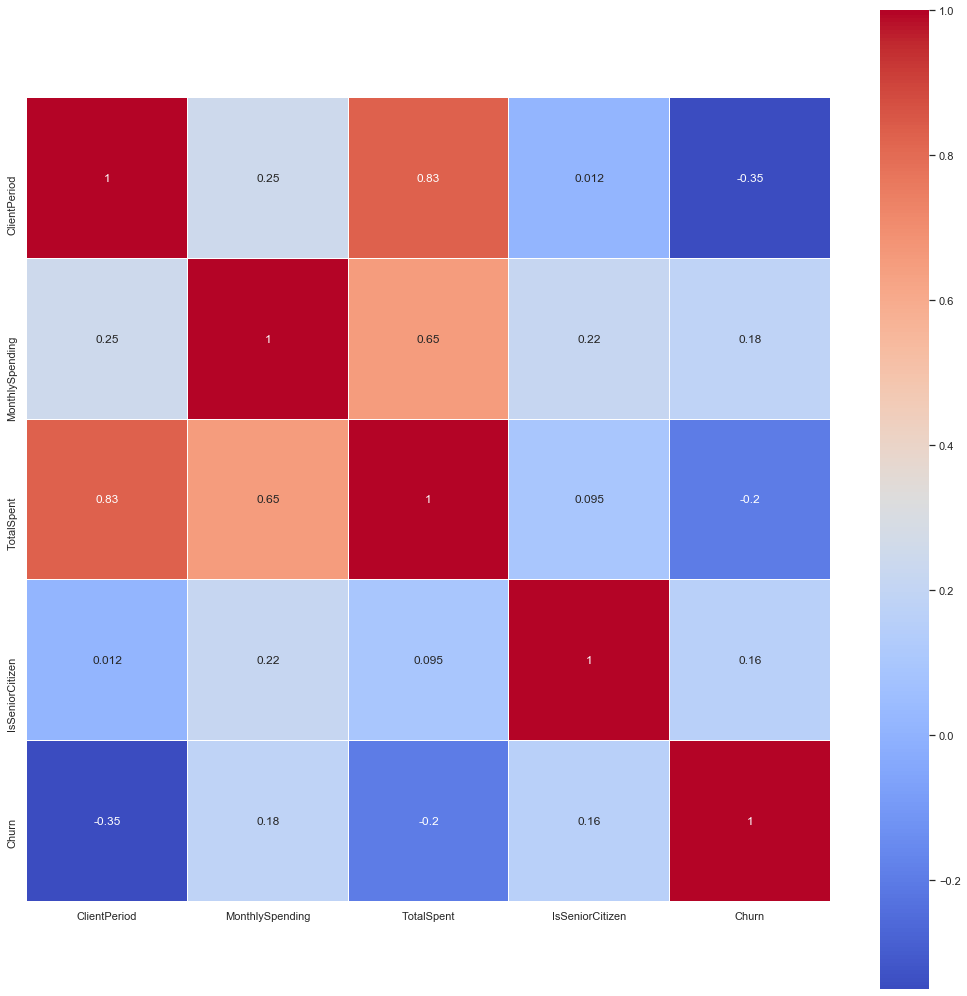

In [10]:
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train_df.corr(), annot=True, linewidths=.1, cmap="coolwarm", square=True)

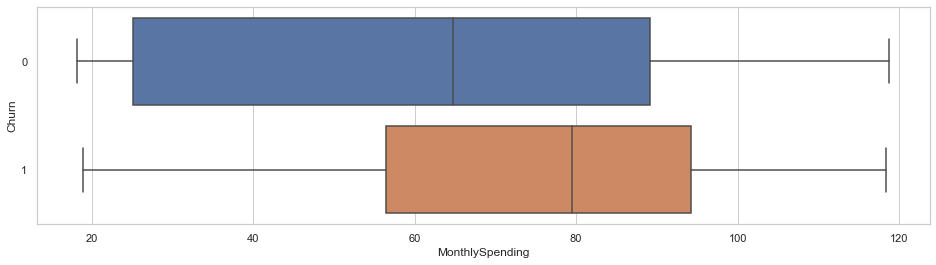

In [11]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.boxplot(x=train_df.MonthlySpending, y=train_df.Churn, orient='h')

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

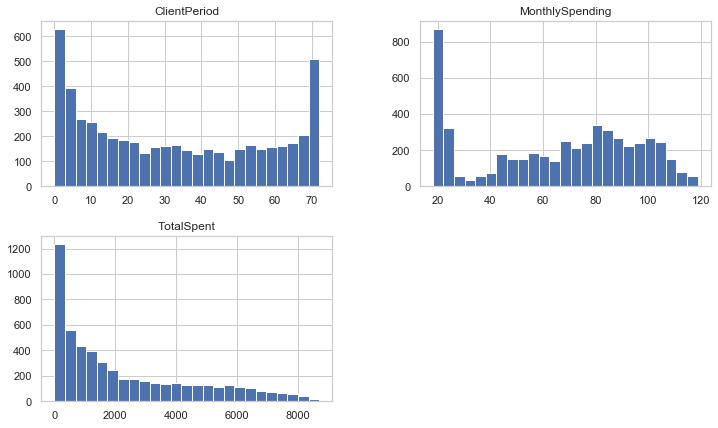

In [14]:
# YOUR CODE
_ = train_df[num_cols].hist(num_cols, figsize=(12, 7), bins=25)

Male      2655
Female    2627
Name: Sex, dtype: int64


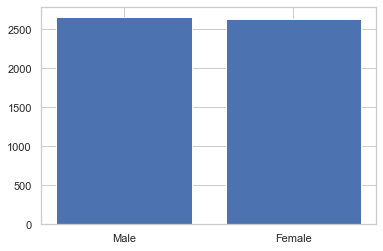

In [15]:
print(train_df['Sex'].value_counts())
values = train_df['Sex'].value_counts().tolist()
index = train_df['Sex'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

0    4440
1     842
Name: IsSeniorCitizen, dtype: int64


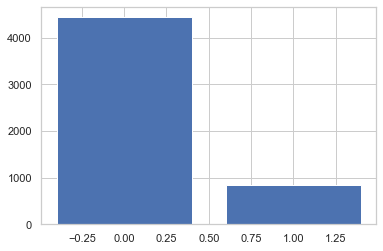

In [16]:
print(train_df['IsSeniorCitizen'].value_counts())
values = train_df['IsSeniorCitizen'].value_counts().tolist()
index = train_df['IsSeniorCitizen'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

No     2705
Yes    2577
Name: HasPartner, dtype: int64


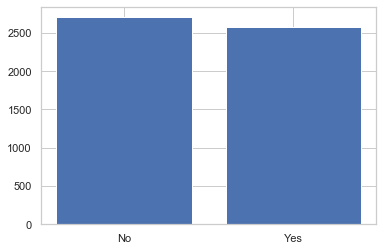

In [17]:
print(train_df['HasPartner'].value_counts())
values = train_df['HasPartner'].value_counts().tolist()
index = train_df['HasPartner'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

No     3676
Yes    1606
Name: HasChild, dtype: int64


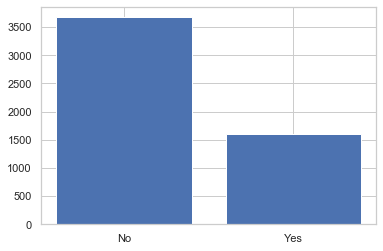

In [18]:
print(train_df['HasChild'].value_counts())
values = train_df['HasChild'].value_counts().tolist()
index = train_df['HasChild'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

Yes    4761
No      521
Name: HasPhoneService, dtype: int64


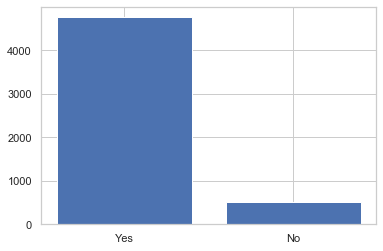

In [19]:
print(train_df['HasPhoneService'].value_counts())
values = train_df['HasPhoneService'].value_counts().tolist()
index = train_df['HasPhoneService'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64


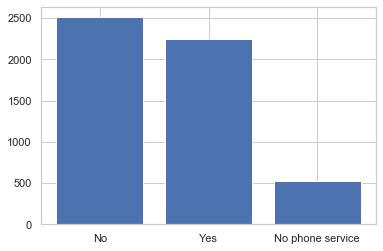

In [20]:
print(train_df['HasMultiplePhoneNumbers'].value_counts())
values = train_df['HasMultiplePhoneNumbers'].value_counts().tolist()
index = train_df['HasMultiplePhoneNumbers'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64


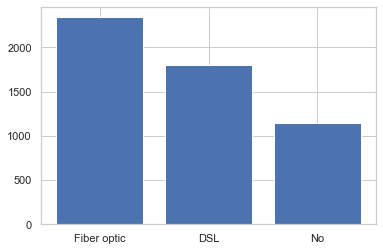

In [21]:
print(train_df['HasInternetService'].value_counts())
values = train_df['HasInternetService'].value_counts().tolist()
index = train_df['HasInternetService'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64


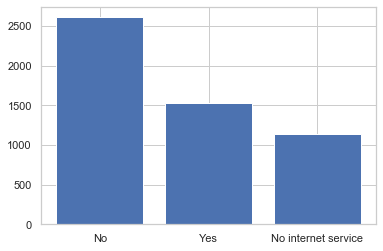

In [22]:
print(train_df['HasOnlineSecurityService'].value_counts())
values = train_df['HasOnlineSecurityService'].value_counts().tolist()
index = train_df['HasOnlineSecurityService'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64


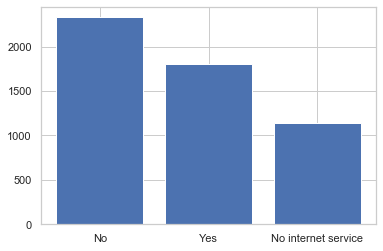

In [23]:
print(train_df['HasOnlineBackup'].value_counts())
values = train_df['HasOnlineBackup'].value_counts().tolist()
index = train_df['HasOnlineBackup'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

No                     2317
Yes                    1824
No internet service    1141
Name: HasDeviceProtection, dtype: int64


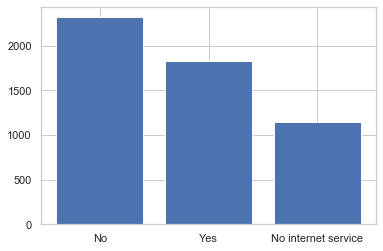

In [24]:
print(train_df['HasDeviceProtection'].value_counts())
values = train_df['HasDeviceProtection'].value_counts().tolist()
index = train_df['HasDeviceProtection'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

No                     2604
Yes                    1537
No internet service    1141
Name: HasTechSupportAccess, dtype: int64


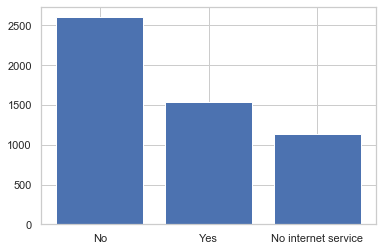

In [25]:
print(train_df['HasTechSupportAccess'].value_counts())
values = train_df['HasTechSupportAccess'].value_counts().tolist()
index = train_df['HasTechSupportAccess'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

No                     2099
Yes                    2042
No internet service    1141
Name: HasOnlineTV, dtype: int64


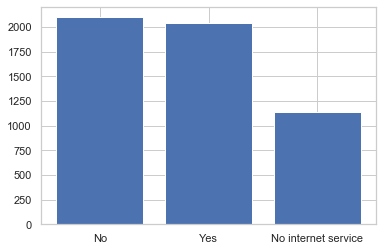

In [26]:
print(train_df['HasOnlineTV'].value_counts())
values = train_df['HasOnlineTV'].value_counts().tolist()
index = train_df['HasOnlineTV'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

No                     2081
Yes                    2060
No internet service    1141
Name: HasMovieSubscription, dtype: int64


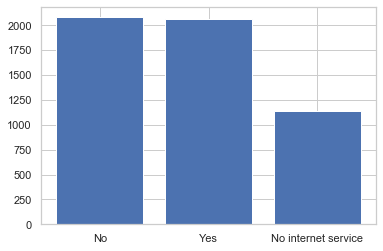

In [27]:
print(train_df['HasMovieSubscription'].value_counts())
values = train_df['HasMovieSubscription'].value_counts().tolist()
index = train_df['HasMovieSubscription'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

Month-to-month    2920
Two year          1280
One year          1082
Name: HasContractPhone, dtype: int64


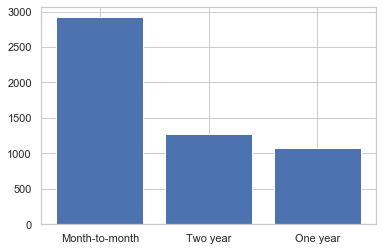

In [28]:
print(train_df['HasContractPhone'].value_counts())
values = train_df['HasContractPhone'].value_counts().tolist()
index = train_df['HasContractPhone'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

Yes    3148
No     2134
Name: IsBillingPaperless, dtype: int64


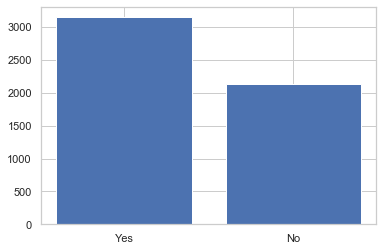

In [29]:
print(train_df['IsBillingPaperless'].value_counts())
values = train_df['IsBillingPaperless'].value_counts().tolist()
index = train_df['IsBillingPaperless'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

Electronic check             1786
Mailed check                 1194
Bank transfer (automatic)    1159
Credit card (automatic)      1143
Name: PaymentMethod, dtype: int64


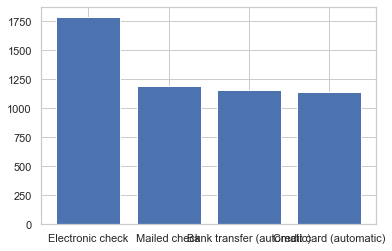

In [30]:
print(train_df['PaymentMethod'].value_counts())
values = train_df['PaymentMethod'].value_counts().tolist()
index = train_df['PaymentMethod'].value_counts().index.tolist()
plt.bar(index, values)
plt.show()

In [31]:
train_df.groupby(['Churn']).size() # датасет нессиметричен 

Churn
0    3898
1    1384
dtype: int64

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [ ]:
# YOUR CODE

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [32]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [58]:
# YOUR CODE
ohe_c = OneHotEncoder(sparse=False)   #кодирование категориальных признаков
ohe_c.fit(train_df[cat_cols])
coded_features_c = ohe_c.transform(train_df[cat_cols])



In [59]:
scaler_c = StandardScaler()    #нормирование числовых признаков
scaler_c.fit(train_df[num_cols])
normalized_features_c = scaler_c.transform(train_df[num_cols])




In [60]:
ind_vars_c = np.concatenate((coded_features_c,normalized_features_c), axis=1)

ind_vars_c

array([[ 0.        ,  1.        ,  1.        , ...,  0.92076704,
        -1.50544655, -0.55585201],
       [ 0.        ,  1.        ,  1.        , ...,  1.61328776,
        -1.29499774, -0.18303943],
       [ 0.        ,  1.        ,  1.        , ..., -1.27900465,
         0.36373662, -0.97476756],
       ...,
       [ 0.        ,  1.        ,  1.        , ..., -1.27900465,
        -0.32726461, -0.9839573 ],
       [ 1.        ,  0.        ,  1.        , ..., -0.13838229,
         0.36705077, -0.03183845],
       [ 1.        ,  0.        ,  1.        , ..., -0.54574742,
         0.36373662, -0.40191834]])

In [63]:
ohe_c_test = OneHotEncoder(sparse=False)
scaler_c_test = StandardScaler() 

ohe_c_test.fit(test_df[cat_cols])
coded_features_c_test = ohe_c_test.transform(test_df[cat_cols])

scaler_c_test.fit(train_df[num_cols])
normalized_features_c_test = scaler_c_test.transform(test_df[num_cols])

ind_vars_c_test = np.concatenate((coded_features_c_test,normalized_features_c_test), axis=1)

In [36]:
model = GridSearchCV(LogisticRegression(), [{'C': [100, 10, 1, 0.1, 0.01, 0.001,]}], scoring='roc_auc')

In [37]:
X = ind_vars_c
Y = train_df['Churn']

In [38]:
model.fit(X,Y)

C:\Users\misha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\misha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [100, 10, 1, 0.1, 0.01, 0.001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [39]:
print(model.best_params_)   #лучшие параметры модели
print(model.best_score_)
print(model.best_estimator_)

{'C': 100}
0.8451148415610076
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [42]:
# YOUR CODE

ModuleNotFoundError: No module named 'catboost'

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [73]:
best_model = model.best_estimator_.predict_proba(ind_vars_c_test)[:, 1]
def write_to_submission_file(predicted_labels, out_file, target='Churn', index_label="Id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(len(predicted_labels)),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


array([0.03705079, 0.73591945, 0.68272839, ..., 0.74948133, 0.64417296,
       0.00960232])

In [72]:

submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict_proba(ind_vars_c_test)[:, 1]
submission.to_csv('./my_submission.csv')


In [77]:
prediction = model.best_estimator_.predict_proba(ind_vars_c_test)[:, 1]
def write_to_submission_file(predicted_labels, out_file, target='Churn', index_label="Id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(len(predicted_labels)),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
write_to_sumbission_file = (prediction,'kaggle.csv')


In [83]:

submission['Churn'] = best_model.predict_proba(ind_vars_c_test)[:, 1]
submission.to_csv('./my_submission.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.